In [3]:
%load_ext autoreload
%autoreload 2

here the objective is to fit the logit graph model to multiple different graph domains and then visualize the original vs fitted graphs

In [4]:

import sys
import os

#Graph imports
sys.path.append('../..')
import src.logit_graph.graph as graph
import src.logit_graph.logit_estimator as estimator
import src.logit_graph.utils as utils
import src.logit_graph.model_selection as model_selection
import src.logit_graph.gic as gic
import src.logit_graph.param_estimator as pe
import src.logit_graph.graph as graph
import src.logit_graph.model_selection as ms

from src.logit_graph.simulation import LogitGraphFitter, GraphModelComparator

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [5]:
data_directory = f'../../data/REDDIT-MULTI-12K'
os.listdir(data_directory)

['component_29614.edges',
 'component_21499.edges',
 'component_21075.edges',
 'component_24884.edges',
 'component_6445.edges',
 'component_11381.edges',
 'REDDIT-MULTI-12K.graph_idx',
 'component_24964.edges',
 'component_30679.edges',
 'component_30194.edges',
 'component_7623.edges',
 'component_31089.edges',
 'component_10825.edges',
 'component_21503.edges',
 'component_30314.edges',
 'component_13288.edges',
 'component_26176.edges',
 'component_1975.edges',
 'component_29904.edges',
 'component_30149.edges',
 'component_2610.edges',
 'component_9126.edges',
 'component_30744.edges',
 'component_21252.edges',
 'component_27156.edges',
 'component_21523.edges',
 'component_3307.edges',
 'component_11345.edges',
 'component_8185.edges',
 'component_6976.edges',
 'component_30357.edges',
 'REDDIT-MULTI-12K.graph_labels',
 'component_29244.edges',
 'component_4003.edges',
 'component_27036.edges',
 'REDDIT-MULTI-12K.readme',
 'component_27427.edges',
 'component_7462.edges',
 'compo

In [6]:
def load_reddit_graph(data_dir, filename):
    """
    Loads a graph from the specified directory and filename.

    Args:
        data_dir (str): The directory where the data is stored.
        filename (str): The name of the file to load.

    Returns:
        networkx.Graph: The loaded graph as a networkx Graph object.
    """
    edge_file = os.path.join(data_dir, filename)
    
    G = nx.Graph()
    
    with open(edge_file, 'r') as f:
        for line in f:
            # The files are comma-separated, so we split the line
            # and convert the node IDs to integers.
            u, v = map(int, line.strip().split(','))
            G.add_edge(u, v)
            
    return G


graphs = []
graph_filepaths = {}
filename = 'REDDIT-MULTI-12K.edges'
graph = load_reddit_graph(data_directory, filename)
if graph:
    graphs.append(graph)
    graph_filepaths[graph] = os.path.join(data_directory, filename)
    print(f"Graph {filename} loaded successfully. Edges: {graph.number_of_edges()}, Nodes: {graph.number_of_nodes()}")


KeyboardInterrupt: 

In [6]:
graph = graphs[0]

import pandas as pd

# Calculate connected components
connected_components = list(nx.connected_components(graph))
component_data = []

# Collect data for each component
for i, component in enumerate(connected_components):
    subgraph = graph.subgraph(component)
    num_nodes = subgraph.number_of_nodes()
    num_edges = subgraph.number_of_edges()
    component_data.append({
        'component': i + 1,
        'num_nodes': num_nodes,
        'num_edges': num_edges
    })

# Create a DataFrame
component_df = pd.DataFrame(component_data)

In [7]:
component_df.sort_values(by='num_nodes', ascending=False).head(100)


,component,num_nodes,num_edges
21522,21523,3760,4058
21518,21519,3642,4003
10871,10872,3624,3766
26780,26781,3606,4334
31789,31790,3533,5166
...,...,...,...
30208,30209,2348,3457
4602,4603,2338,2798
3921,3922,2338,2587
5027,5028,2337,2582


In [8]:
import os
target_directory = data_directory
selected_components = component_df[(component_df['num_nodes'] >= 950) & (component_df['num_nodes'] <= 5000)]
selected_components = selected_components.sample(100)
selected_components

,component,num_nodes,num_edges
8558,8559,1392,1480
13287,13288,1669,1997
27640,27641,973,1134
5662,5663,1682,2006
28487,28488,1508,1938
...,...,...,...
28806,28807,1122,1618
10810,10811,2150,2537
29961,29962,1277,1589
4947,4948,1065,1195


In [9]:
for index, row in selected_components.iterrows():
    component_index = row['component']
    component_nodes = connected_components[component_index - 1]
    subgraph = graph.subgraph(component_nodes)
    
    # Define the file path
    filepath = os.path.join(target_directory, f"component_{component_index}.edges")
    
    # Write the edges to the file
    with open(filepath, 'w') as f:
        for u, v in subgraph.edges():
            f.write(f"{u},{v}\n")
    
    print(f"Component {component_index} saved with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")


Component 8559 saved with 1392 nodes and 1480 edges.
Component 13288 saved with 1669 nodes and 1997 edges.
Component 27641 saved with 973 nodes and 1134 edges.
Component 5663 saved with 1682 nodes and 2006 edges.
Component 28488 saved with 1508 nodes and 1938 edges.
Component 7462 saved with 1002 nodes and 1135 edges.
Component 27156 saved with 1045 nodes and 1453 edges.
Component 25148 saved with 971 nodes and 1188 edges.
Component 27427 saved with 1216 nodes and 1486 edges.
Component 29614 saved with 1457 nodes and 1909 edges.
Component 4729 saved with 1320 nodes and 1551 edges.
Component 21309 saved with 1575 nodes and 2049 edges.
Component 26176 saved with 1056 nodes and 1498 edges.
Component 21075 saved with 3196 nodes and 3543 edges.
Component 21493 saved with 3034 nodes and 3587 edges.
Component 29727 saved with 1472 nodes and 1885 edges.
Component 21007 saved with 1222 nodes and 1394 edges.
Component 30149 saved with 1542 nodes and 1736 edges.
Component 7615 saved with 1757 nod

In [10]:
ids = []
for index, row in selected_components.iterrows():
    component_index = row['component']
    ids.append(component_index)

ids

[8559,
 13288,
 27641,
 5663,
 28488,
 7462,
 27156,
 25148,
 27427,
 29614,
 4729,
 21309,
 26176,
 21075,
 21493,
 29727,
 21007,
 30149,
 7615,
 10947,
 2805,
 26653,
 7773,
 7530,
 24884,
 27036,
 4003,
 29852,
 11279,
 28089,
 12414,
 2610,
 30744,
 6445,
 10825,
 6722,
 3663,
 7672,
 9126,
 30314,
 26366,
 19926,
 11381,
 21499,
 29244,
 10985,
 7623,
 4847,
 5871,
 30194,
 25411,
 7086,
 29904,
 12958,
 32053,
 29130,
 32338,
 24964,
 17776,
 7325,
 24560,
 21503,
 6711,
 7091,
 11260,
 8066,
 5301,
 5404,
 30237,
 21252,
 21533,
 29510,
 30403,
 11345,
 6976,
 27829,
 3307,
 31089,
 4262,
 21555,
 27991,
 6830,
 11047,
 21523,
 9031,
 31577,
 30534,
 21104,
 30357,
 8185,
 30177,
 13918,
 4097,
 4153,
 30679,
 28807,
 10811,
 29962,
 4948,
 13104]

In [11]:
for id in ids:
    # load the graph
    graph_file = f'../../data/REDDIT-MULTI-12K/component_{id}.edges'
    g = nx.read_edgelist(graph_file, nodetype=int, delimiter=',')
    if g.number_of_nodes() == 0 or g.number_of_edges() == 0:
        print(f"Component {id} has no nodes or edges.")
    else:
        print(g.number_of_nodes(), g.number_of_edges())

1392 1480
1669 1997
973 1134
1682 2006
1508 1938
1002 1135
1045 1453
971 1188
1216 1486
1457 1909
1320 1551
1575 2049
1056 1498
3196 3543
3034 3587
1472 1885
1222 1394
1542 1736
1757 2127
1463 1624
1723 1887
1633 1999
991 1080
1006 1230
1217 1419
1277 1455
1225 1501
1363 1983
1774 2061
1380 1841
1116 1240
976 1111
1622 2034
1213 1428
2035 2329
1912 2308
1517 1626
1377 1482
1298 1436
2880 3989
951 1160
1621 1872
1964 2149
3253 3689
1736 2360
2234 2584
1626 2077
1378 1600
955 1200
1036 1193
1170 1502
1360 1530
1203 1557
1498 1765
1309 1806
1065 1334
1745 2354
3020 4088
1442 1713
994 1106
1003 1276
1642 1941
1162 1305
1203 1392
1099 1199
1046 1151
1202 1400
1021 1143
1088 1505
1632 1864
2481 3012
1148 1397
1334 1722
1025 1207
1367 1641
1047 2485
1155 1279
1036 1190
955 1103
2586 2813
1142 1523
1767 2047
1169 1375
3760 4058
954 1047
2737 3943
2449 2976
1576 1901
987 1263
1239 1362
2156 2764
1476 1935
1206 1324
1015 1126
1168 1466
1122 1618
2150 2537
1277 1589
1065 1195
1005 1257


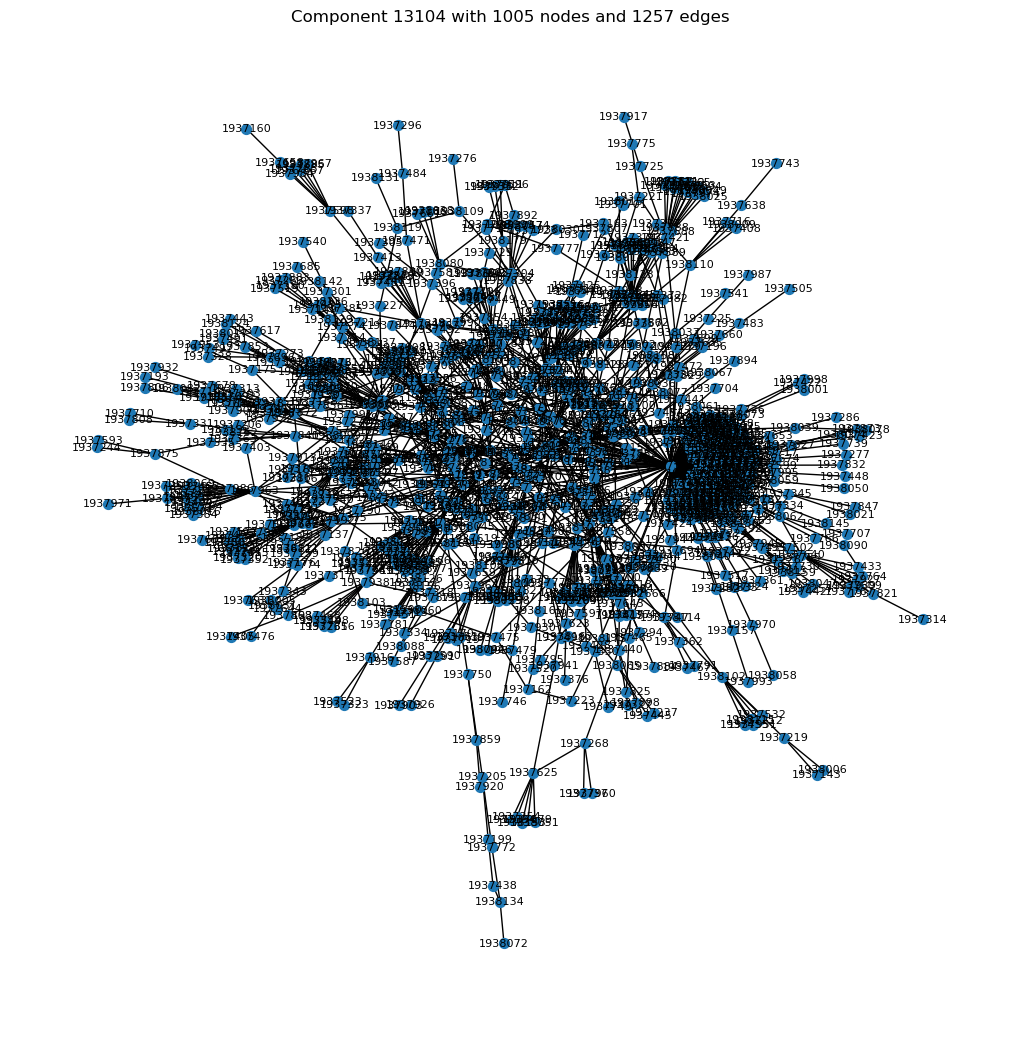

In [12]:
import matplotlib.pyplot as plt
import networkx as nx

# Load the graph from the saved file
filepath = os.path.join(target_directory, f"component_{component_index}.edges")
loaded_graph = nx.read_edgelist(filepath, delimiter=',', nodetype=int)

# Plot the loaded graph
plt.figure(figsize=(10, 10))
nx.draw(loaded_graph, with_labels=True, node_size=50, font_size=8)
plt.title(f"Component {component_index} with {loaded_graph.number_of_nodes()} nodes and {loaded_graph.number_of_edges()} edges")
plt.show()

### Fitting single graph

Loading the different graphs into a networkx graph

In [32]:
# Let's proceed with the first loaded graph if available
if not graphs:
    print("\nNo graphs were loaded. Exiting example.")
    exit()

target_graph = graphs[1]
target_filepath = graph_filepaths[target_graph]

# For a single fit, you need to specify a single `d`
fitter_params = {
    "d": 0,
    "n_iteration": 8000,
    "patience": 10,
    "er_p": 0.05,
    "edge_delta": 50,
    "min_gic_threshold": 0.1,
    "verbose": True
}

# Initialize the fitter with the parameters

lg_fitter = LogitGraphFitter(**fitter_params)
lg_fitter.fit(target_graph)



==================== Processing Graph ====================
Original graph - Nodes: 218, Edges: 1725
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2121
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 196.9655
   🔗 Edges in best graph: 1776 (Real graph edges: 1725)
Fitting successful - GIC: 0.2101, Best iteration: 634
Fitted graph - Nodes: 218, Edges: 1776


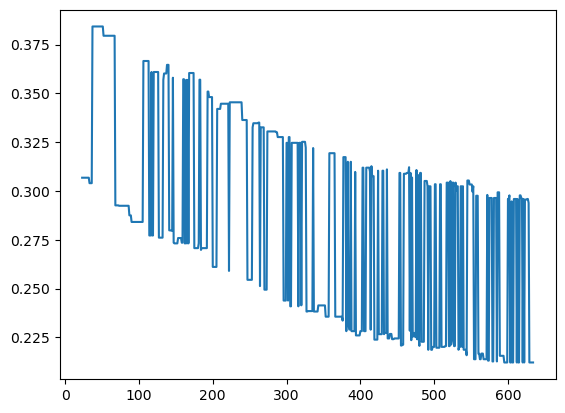

In [33]:
# Log the gic also with the spectrum digg and edges
plt.plot(lg_fitter.metadata['gic_values'])

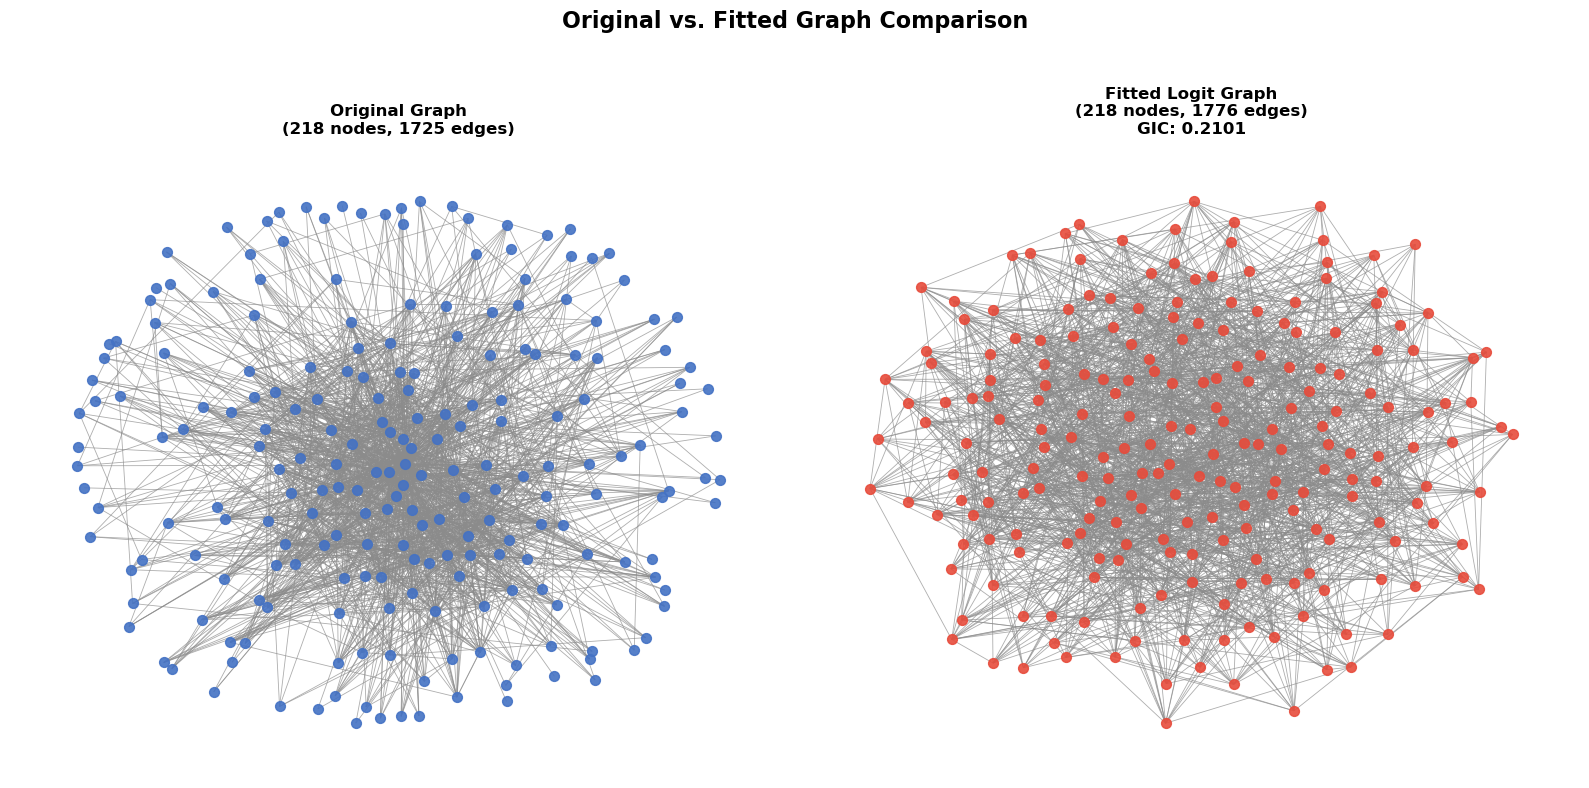

In [34]:
def compare_graphs_visually(original_graph, fitted_graph, metadata=None, figsize=(16, 8), node_size=50, edge_width=0.6):
    """
    Generates a side-by-side plot of the original and fitted graphs.

    Args:
        original_graph (nx.Graph): The original graph.
        fitted_graph (nx.Graph): The fitted graph (can be None if fitting failed).
        metadata (dict, optional): Fitting metadata to display in titles.
        figsize (tuple): The size of the matplotlib figure.
        node_size (int): The size of the nodes in the plot.
        edge_width (float): The width of the edges in the plot.

    Returns:
        matplotlib.figure.Figure: The figure object for the plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Define colors and use a consistent layout for better comparison
    original_node_color = '#4472C4'
    fitted_node_color = '#E74C3C'
    edge_color = '#8B8B8B'
    
    # Calculate layout for original graph
    pos_orig = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
    
    # 1. Plot Original Graph
    ax_orig = axes[0]
    stats_orig = f"{original_graph.number_of_nodes()} nodes, {original_graph.number_of_edges()} edges"
    nx.draw_networkx_edges(original_graph, pos_orig, ax=ax_orig, edge_color=edge_color, width=edge_width, alpha=0.7)
    nx.draw_networkx_nodes(original_graph, pos_orig, ax=ax_orig, node_color=original_node_color, node_size=node_size, alpha=0.9)
    ax_orig.set_title(f'Original Graph\n({stats_orig})', fontweight='bold', pad=10)
    ax_orig.axis('off')

    # 2. Plot Fitted Graph
    ax_fitted = axes[1]
    title = 'Fitted Logit Graph'
    if fitted_graph and metadata and metadata.get('fit_success'):
        stats_fitted = f"{fitted_graph.number_of_nodes()} nodes, {fitted_graph.number_of_edges()} edges"
        gic_val = metadata.get('gic_value', 'N/A')
        gic_text = f"GIC: {gic_val:.4f}" if isinstance(gic_val, (int, float)) else f"GIC: {gic_val}"
        title = f'{title}\n({stats_fitted})\n{gic_text}'
        
        # Calculate separate layout for fitted graph to avoid position mismatch
        pos_fitted = nx.spring_layout(fitted_graph, k=1, iterations=50, seed=42)
        
        nx.draw_networkx_edges(fitted_graph, pos_fitted, ax=ax_fitted, edge_color=edge_color, width=edge_width, alpha=0.7)
        nx.draw_networkx_nodes(fitted_graph, pos_fitted, ax=ax_fitted, node_color=fitted_node_color, node_size=node_size, alpha=0.9)
    else:
        title = f'{title}\n(Fitting Failed)'
        ax_fitted.text(0.5, 0.5, 'Fitting Failed', horizontalalignment='center', verticalalignment='center', transform=ax_fitted.transAxes, fontsize=14, color='red')

    ax_fitted.set_title(title, fontweight='bold', pad=10)
    ax_fitted.axis('off')
    
    fig.suptitle('Original vs. Fitted Graph Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig


# 5. Visualize the results
if lg_fitter.metadata['fit_success']:
    comparison_figure = compare_graphs_visually(target_graph, lg_fitter.fitted_graph, lg_fitter.metadata)
    plt.show()
else:
    print("Fitting failed. No visualization available.")


In [50]:
# Let's proceed with the first loaded graph if available
if not graphs:
    print("\nNo graphs were loaded. Exiting example.")
    exit()

target_graph = graphs[2]
target_filepath = graph_filepaths[target_graph]

# For a single fit, you need to specify a single `d`
sim_params = {
    "d_list": [0, 1, 2],
    "lg_params": {
        "max_iterations": 8000,
        "patience": 10,
        "gic_dist_type": 'KL',
        "er_p": 0.05,
        "min_gic_threshold": 0.1,
        "edge_delta": 50,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.2},  # ER (probability)
        {'k': {'lo': 2, 'hi': 3, 'step': 1}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},      # GRG (alpha)
        {'lo': 3, 'hi': 5},     # BA (m)
    ],
    "verbose": True,
}



# Initialize the fitter with the parameters

comparator = GraphModelComparator(**sim_params)
comparator.compare(target_graph, target_filepath)



============================== Processing Graph: 96907622.edges ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4346 (Target: ≤0.1) 📈 Best Spectrum Diff: 572.4733 ⏱️  Patience: 0/10 🔗 Edges: 1766 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3615 (Target: ≤0.1) 📈 Best Spectrum Diff: 474.1305 ⏱️  Patience: 0/10 🔗 Edges: 2633 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4667 (Target: ≤0.1) 📈 Best Spectrum Diff: 403.6383 ⏱️  Patience: 0/10 🔗 Edges: 3453 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2190 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.5826 ⏱️  Patience: 0/10 🔗 Edges: 4234 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4033
   📈 Results Summary
   🏆 Best iteration found: 4,584
   📊 Best spectrum difference: 348.8605
   🔗 Edges in best graph: 4674 (Real graph edges: 4649)
d=0: GIC=0.2042, sigma=-5.4737
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4181 (Target: ≤0.1) 📈 Best Spectrum Diff: 566.4874 ⏱️  Patience: 0/10 🔗 Edges: 1813 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5644 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.9589 ⏱️  Patience: 0/10 🔗 Edges: 2678 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4667 (Target: ≤0.1) 📈 Best Spectrum Diff: 400.6161 ⏱️  Patience: 0/10 🔗 Edges: 3511 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2135 (Target: ≤0.1) 📈 Best Spectrum Diff: 359.2674 ⏱️  Patience: 0/10 🔗 Edges: 4275 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4069
   📈 Results Summary
   🏆 Best iteration found: 4,528
   📊 Best spectrum difference: 351.4274
   🔗 Edges in best graph: 4660 (Real graph edges: 4649)
d=1: GIC=0.4069, sigma=-6.2316
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4336 (Target: ≤0.1) 📈 Best Spectrum Diff: 569.1227 ⏱️  Patience: 0/10 🔗 Edges: 1812 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5529 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.6666 ⏱️  Patience: 0/10 🔗 Edges: 2689 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2589 (Target: ≤0.1) 📈 Best Spectrum Diff: 404.2305 ⏱️  Patience: 0/10 🔗 Edges: 3486 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2111 (Target: ≤0.1) 📈 Best Spectrum Diff: 364.2727 ⏱️  Patience: 0/10 🔗 Edges: 4277 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4048
   📈 Results Summary
   🏆 Best iteration found: 4,409
   📊 Best spectrum difference: 358.2911
   🔗 Edges in best graph: 4577 (Real graph edges: 4649)
d=2: GIC=0.2048, sigma=-80.5871
Best LG fit found with GIC: 0.2042

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2723181008317491
Tes

In [52]:
comparator.summary_df

,graph_filename,model,gic_value,param,fit_success,nodes,edges,density,avg_clustering,avg_path_length,diameter,assortativity,num_components,largest_component_size
0,96907622.edges,Original,NaN,N/A,True,187,4649,0.267322,0.598147,1.749955,4,-0.223390,2,183
1,96907622.edges,LG,0.204187,"d=0, sigma=-5.4737",True,187,4674,0.268760,0.269265,1.731240,2,-0.021158,1,187
2,96907622.edges,ER,0.272318,0.2,True,187,3385,0.194641,0.196904,1.806107,3,-0.001703,1,187
3,96907622.edges,BA,0.721498,5.0,True,187,910,0.052326,0.129281,2.433673,4,-0.115371,1,187
4,96907622.edges,WS,1.599264,20.2,True,187,4675,0.268817,0.266414,1.731183,2,-0.042454,1,187
5,96907622.edges,GRG,2.135166,1.0,True,187,16891,0.971249,0.975021,1.028751,2,-0.046187,1,187


### Comparison other models

comparing multiple models

In [20]:
import os
import re

files = os.listdir('../../data/REDDIT-MULTI-12K')
ids = []
for file in files:
    if file.endswith('.edges'):
        match = re.search(r'component_(\d+)\.edges$', file)
        if match:
            ids.append(int(match.group(1)))
print(ids)

[29614, 21499, 21075, 24884, 6445, 11381, 24964, 30679, 30194, 7623, 31089, 10825, 21503, 30314, 13288, 26176, 1975, 29904, 30149, 2610, 9126, 30744, 21252, 27156, 21523, 3307, 11345, 8185, 6976, 30357, 29244, 4003, 27036, 27427, 7462, 27829, 6830, 4847, 4729, 11279, 30237, 4262, 28807, 11260, 29962, 2805, 27641, 32338, 7091, 28488, 29510, 10947, 30403, 30177, 21309, 6722, 5301, 10985, 11047, 27991, 8066, 17776, 25411, 30534, 5404, 7086, 3599, 10811, 29130, 7530, 6711, 2848, 3726, 13918, 7615, 8559, 21104, 3586, 31577, 3663, 3440, 3235, 7672, 21533, 12414, 29852, 5871, 4077, 19926, 7325, 5663, 21555, 4948, 7773, 29727, 21493, 21007, 26653, 24560, 13104, 32053, 26366, 25148, 12958, 4097, 28089, 2156, 9031, 4153]


In [21]:
import os
import re

files = os.listdir('runs/fitted_graphs_comparison_reddit3/')
done_ids = []
for file in files:
    if file.endswith('.pkl'):
        match = re.search(r'comparators_component_(\d+)\.pkl$', file)
        if match:
            done_ids.append(int(match.group(1)))
print(done_ids)

[29614, 21075, 4729, 26653, 2610, 25148, 30744, 7530, 29852, 21007, 8559, 13288, 4003, 12414, 26176, 5663, 27641, 10947, 11279, 29727, 10825, 7462, 27156, 7773, 6445, 21309, 27036, 28488, 2805, 27427, 24884, 21493, 7615, 30149, 28089]


In [22]:
# ex
print(len(ids))
ids = [id for id in ids if id not in done_ids]
print(len(ids))

109
74


In [23]:
sim_params = {
    "d_list": [0, 1, 2],
    "lg_params": {
        "max_iterations": 8000,
        "patience": 10,
        "gic_dist_type": 'KL',
        "er_p": 0.001,
        "min_gic_threshold": 0.1,
        "edge_delta": 50,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.2},  # ER (probability)
        {'k': {'lo': 2, 'hi': 3, 'step': 1}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},      # GRG (alpha)
        {'lo': 1, 'hi': 5},     # BA (m)
    ],
    "verbose": True,
}



graph_files = []
for id in ids:
    graph_files.append(f'../../data/REDDIT-MULTI-12K/component_{id}.edges')
print(len(graph_files))

graphs = [nx.read_edgelist(f, nodetype=int) for f in graph_files]


74


In [ ]:

comparators = []
folder_name = 'runs/fitted_graphs_comparison_reddit3'
os.makedirs(folder_name, exist_ok=True)

for graph_file in graph_files:
    try:
        print(f"Loading graph from: {graph_file}")
        original_graph = nx.read_edgelist(graph_file, nodetype=int, delimiter=',')

        n_iteration = 10_000
        sim_params['lg_params']['max_iterations'] = n_iteration

        # Run the comparison
        comparator = GraphModelComparator(**sim_params)
        comparator.compare(original_graph, graph_file)
    except Exception as e:
        print(f"Error graph from {graph_file}: {e}")
        continue

    comparators.append(comparator)
    import pickle
    graph_name = graph_file.split('/')[-1].split('.')[0]
    with open(f'{folder_name}/comparators_{graph_name}.pkl', 'wb') as f:
        pickle.dump(comparators, f)



Loading graph from: ../../data/REDDIT-MULTI-12K/component_21499.edges

============================== Processing Graph: component_21499.edges ==============================

--- Fitting Logit Graph (LG) model ---


In [37]:
21321

21321